In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [39]:
store_sales = pd.read_csv('sales.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [40]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [41]:
store_sales = store_sales.drop(['store','item'], axis=1)
store_sales.head(10)

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
5,2013-01-06,12
6,2013-01-07,10
7,2013-01-08,9
8,2013-01-09,12
9,2013-01-10,9


In [42]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [43]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [44]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


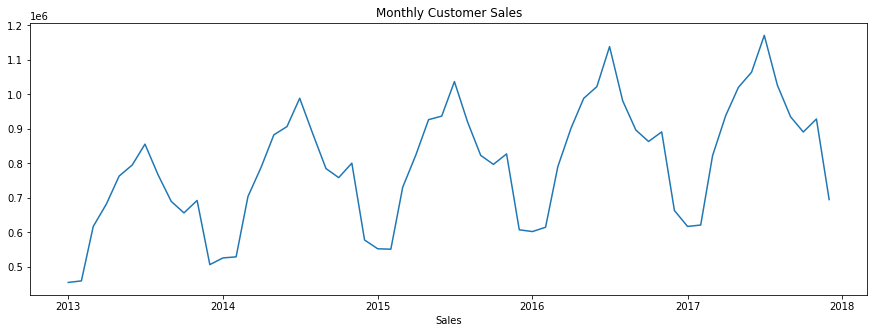

In [45]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()

In [46]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


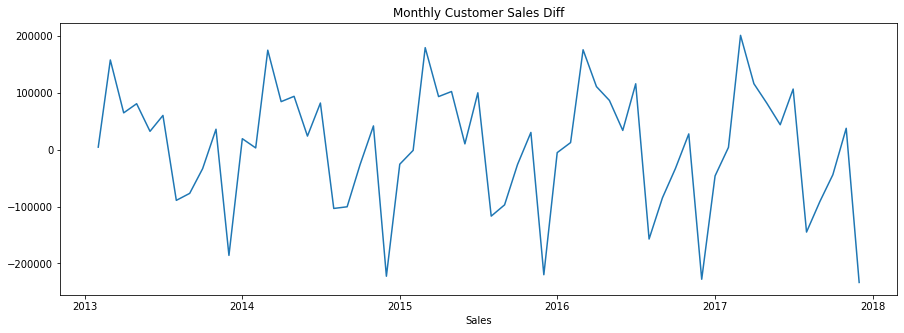

In [47]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales Diff")
plt.show()

In [48]:
supverised_data = monthly_sales.drop(['date','sales'], axis=1)

In [49]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supverised_data[col_name] = supverised_data['sales_diff'].shift(i)
supverised_data = supverised_data.dropna().reset_index(drop=True)
supverised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [50]:
train_data = supverised_data[:-12]
test_data = supverised_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [51]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [52]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (35, 12)
y_train Shape: (35,)
X_test Shape: (12, 12)
y_test Shape: (12,)


In [53]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [54]:
act_sales = monthly_sales['sales'][-13:].to_list()

# **`Forecast Sales using Linear Regression`**

In [55]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

In [56]:
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

In [57]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

In [58]:
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  16221.272385416898
Linear Regression MAE:  12433.184266490765
Linear Regression R2 Score:  0.9906152516380968


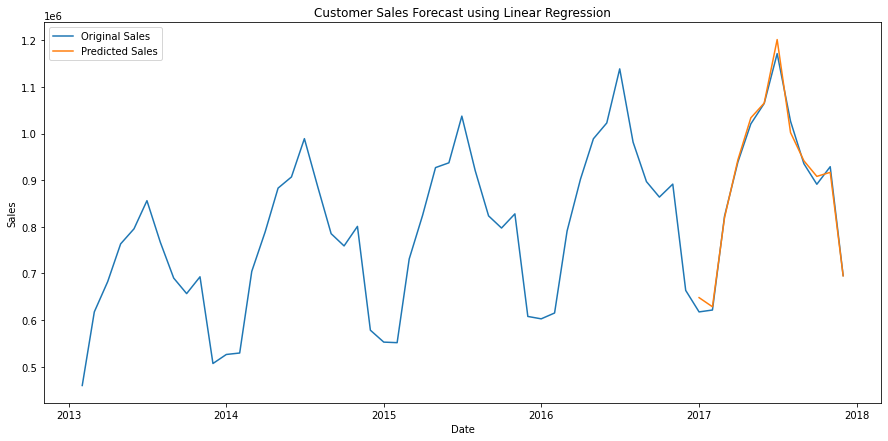

In [59]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()